In [1]:
using PyPlot, Optim, Statistics, CSV

PyPlot.matplotlib.style.use("fivethirtyeight")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16
rcParams["lines.linewidth"] = 3

3

two resources to guide you for this studio:
* my [Optim.jl demo](https://nbviewer.jupyter.org/github/SimonEnsemble/control_theory_demos/blob/master/demos/Optimization.ipynb)
* my [notes on the dynamics of the heat transfer to/from this thermistor](https://my.pcloud.com/publink/show?code=XZWNuDkZ3EnxLCCa2v8jniHJOfqbiSbTfIwX)

# empirical model for thermistor heat transfer dynamics

Grant grabbed and held the thermistor for a long time; the temperature of the thermistor eventually equilibrated with Grant's body temperature. then, at $t=0$, Grant let go of the thermistor. at this point, heat is transferred from the thermistor to the air at ambient temperature. so, we see the temperature of the thermistor drop and approach ambient temperature.

<img src="https://www.avx.com/en/wp-content/uploads/product-images/Thermistor-Disc-Leaded.jpg" width=200>

let $T=T(t)$ be the temperature of the thermistor as a function of time. 

## reading in the data
the time series data characterizing $T(t)$ is in the comma-separated-value (`.csv`) file `ambient_heat_transfer.csv`. we use the package `CSV.jl` to read this file. make sure you place the `.csv` file in your present working directory `pwd()` so that `CSV.jl` can find it. the resulting data type is a `DataFrame`, a convenient and widely used data structure for working with data.

In [2]:
df = CSV.read("ambient_heat_transfer.csv") # read in the .csv file as a DataFrame, df
first(df, 5) # display the first 5 rows

,time,temperature
,Float64,Float64
1,-10.0,35.35
2,-9.9,35.8
3,-9.8,35.8
4,-9.7,35.8
5,-9.6,35.8


since you aren't so accustomed with `DataFrame`s, let's instead unpack the data into two arrays `t` (time) and `T` (temperature).

the `:` tells us "grab all the rows" and the next argument is the column name we want to extract from the `DataFrame`. I'm declaring this as a constant `const` to prevent you from accidentally overwriting these variables.

In [3]:
const t = df[:, :time] # seconds

601-element Array{Float64,1}:
 -10.0
  -9.9
  -9.8
  -9.7
  -9.6
  -9.5
  -9.4
  -9.3
  -9.2
  -9.1
  -9.0
  -8.9
  -8.8
   ⋮  
  48.9
  49.0
  49.1
  49.2
  49.3
  49.4
  49.5
  49.6
  49.7
  49.8
  49.9
  50.0

In [4]:
const T = df[:, :temperature] # degrees C

601-element Array{Float64,1}:
 35.35
 35.8 
 35.8 
 35.8 
 35.8 
 34.9 
 35.35
 35.35
 35.35
 35.35
 35.8 
 35.8 
 35.35
  ⋮   
 19.71
 19.71
 20.22
 19.45
 19.21
 19.96
 19.21
 19.45
 19.71
 19.71
 19.96
 19.45

## visualizing the data

(1) plot the time series data to visualize the response $T(t)$ of the thermistor. label your axes and include appropriate units.

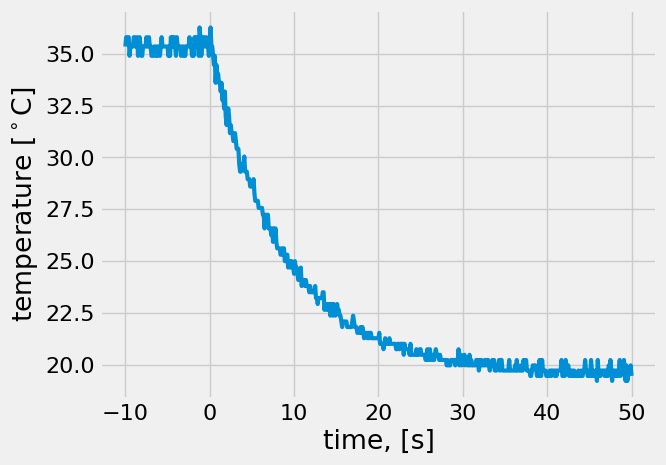

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f25202a48d0>

In [5]:
figure()
xlabel("time, [s]")
ylabel(L"temperature [$^\circ$C]")
plot(t, T)

let's calculate the temperature of Grant's finger by taking the average of the temperature reading when $t<0$. during this time, Grant was still holding onto the thermistor. so, we assume the thermistor was in thermal equilibrium with Grant's hand.

In [6]:
T_Grant = mean(T[t .< 0.0]) # degrees Celcius

35.372699999999995

let's calculate the ambient temperature by taking the average of the temperature for $t>40$ where we assume the thermistor has reached thermal equilibrium with the ambient air.

In [7]:
T_ambient = mean(T[t .> 40.0]) # degrees Celcius

19.639400000000002

(2) in addition to visualizing $T(t)$ as in question (1), also include two horizontal, dashed lines that indicate `T_Grant` and `T_ambient`. give them `label`s and include a legend to indicate what each curve represents.

you should see the temperature of the thermistor go from `T_Grant` to `T_ambient`.

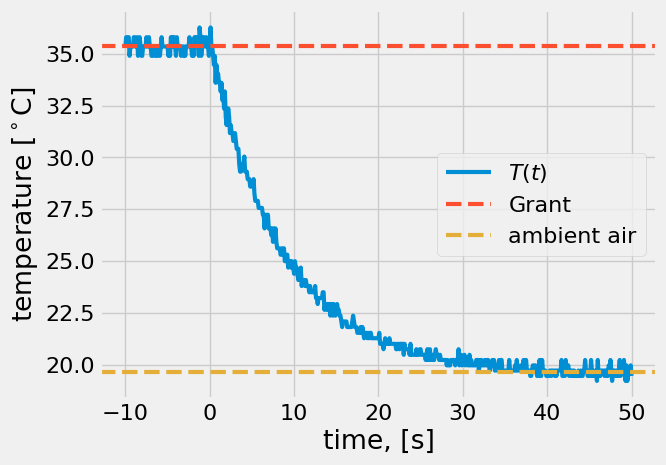

PyObject <matplotlib.legend.Legend object at 0x7f250fd3d6a0>

In [8]:
figure()
xlabel("time, [s]")
ylabel(L"temperature [$^\circ$C]")
plot(t, T, label=L"$T(t)$")
axhline(y=T_Grant, label="Grant", color="C1", linestyle="--")
axhline(y=T_ambient, label="ambient air", color="C2", linestyle="--")
legend()

## fitting an empirical model

we derived the following ODE model in class for the thermistor temperature $T(t)$ [the output] in response to the external temperature $T_e(t)$ imposed [the input].

\begin{equation}
\frac{C}{UA}\frac{dT}{dt} + T = T_e.
\end{equation}

* $U$: heat transfer coefficient
* $A$: surface area
* $C$: thermal capacity

thus this is a first order process with time constant $\tau:=C/UA$.

i.e. the transfer function for this process is:

$$G(s)=\frac{\mathcal{T}^*(s)}{\mathcal{T}^*_e(s)}=\frac{1}{\tau s +1}$$

(see lecture notes on Canvas "thermistor dynamics")

**the goal** of this studio is to use the data to emperically identify the time constant $\tau$ of this process. this is in contrast to measuring $C$, $U$, and $A$ of the thermistor separately.

(3) consider the steady state condition as the thermistor being in thermal equilibrium with Grant's hand.

what kind of input to the system does this experiment correspond to? what is the magnitude of this input change? assign the magnitude as a variable `M`. you can calculate it from variables above. think carefully about the sign of the magnitude.

a step input

In [9]:
M = T_ambient - T_Grant # deg. C

-15.733299999999993

(4) **given** a guess for the time constant $\tau$, write a function `T_model(t, τ)` that returns the temperature according to the first order model for $T(t)$ and specified time constant $\tau$. you will need an `if` statement for when `t<0` and `t>0`. (see [docs](https://docs.julialang.org/en/v1/manual/control-flow/#man-conditional-evaluation-1))

In [10]:
function T_model(t, τ) 
    if t < 0.0
        return T_Grant
    else
        return T_Grant .+ M * (1.0 - exp(-t / τ))
    end
end

T_model (generic function with 1 method)

(5) write a function `cost(τ)` that computes the cost function for a given guess for `τ`. as the "cost", use the sum of square errors between the predicted temperature and actual temperature. we seek to minimize the cost to determine the time constant `τ`. 

In [11]:
function cost(τ)
    ℓ = 0.0
    for i = 1:length(t)
        ℓ += (T[i] - T_model(t[i], τ)) ^ 2
    end
    return ℓ
end

cost (generic function with 1 method)

(6) plot the cost function for $\tau \in [0, 50]$. does it have a minimum?

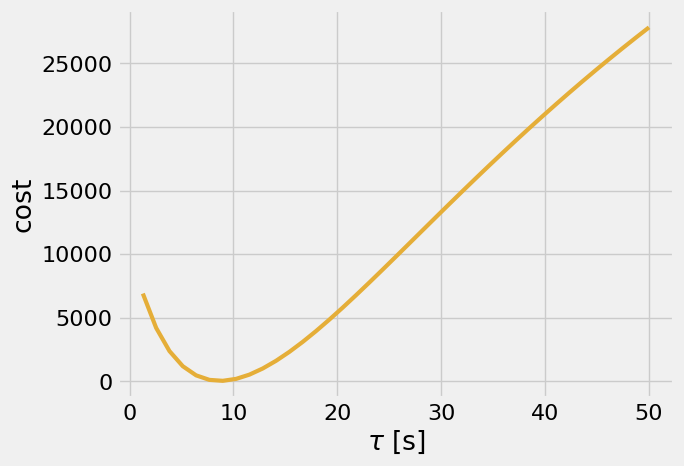

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f250fcdc400>

In [12]:
τs = range(0.0, 50.0, length=40)

figure()
xlabel(L"$\tau$ [s]")
ylabel("cost")
plot(τs, cost.(τs), color="C2")

(7) use the `optimize` function in `Optim.jl` to minimize the cost function you wrote. assign the optimum value of $\tau$ as a variable `τ_opt`. what is the optimal value of $\tau$ that best fits the data? what are the units?

see [Optim.jl docs](https://julianlsolvers.github.io/Optim.jl/stable/#user/minimization/#minimizing-a-univariate-function-on-a-bounded-interval) on minimizing a uni-variate function if you are struggling.

In [13]:
opt_res = optimize(cost, 0.0, 50.0)

τ_opt = opt_res.minimizer

println("optimum τ = ", τ_opt, " s")

optimum τ = 8.707239479378025 s


(8) finally, plot the model fit on top of the data using `τ_opt` and your `T_model` function. does it fit well? (if it doesn't, you did something wrong!)

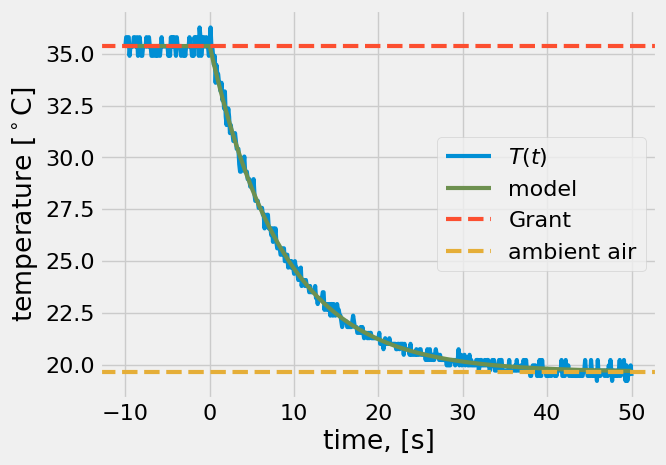

PyObject <matplotlib.legend.Legend object at 0x7f250be04f28>

In [14]:
T_pred = [T_model(t_i, τ_opt) for t_i in t]
    
figure()
xlabel("time, [s]")
ylabel(L"temperature [$^\circ$C]")
plot(t, T, label=L"$T(t)$")
plot(t, T_pred, label="model", color="C3")
axhline(y=T_Grant, label="Grant", color="C1", linestyle="--")
axhline(y=T_ambient, label="ambient air", color="C2", linestyle="--")
legend()

(9) we can now use the empirical model to simulate the response of the thermistor in different contexts.

plot the response $T^*(t)$ to a ramp input in temperature, where the air is warmed by a heater at rate $0.01$ K/s. simulate the response for two minutes.

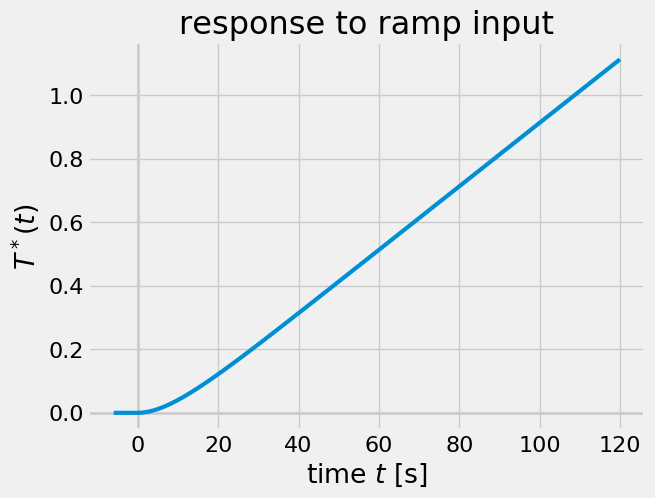

In [15]:
using Controlz

g = 1 / (τ_opt * s + 1)
Te_of_s = 0.01 / s ^ 2
T_of_s = g * Te_of_s

t_ramp, T_ramp = simulate(T_of_s, 60.0 * 2)

viz_response(t_ramp, T_ramp, plot_title="response to ramp input", 
    plot_ylabel=L"$T^*(t)$", plot_xlabel=L"time $t$ [s]")

*note*: think about how we baked into this problem the assumption that the gain $K=1$. to confirm this, we would need a reference thermometer that independently measures the temperature of the ambient air and of Grant's finger.